### Import Library

In [ ]:
# Mengimpor pustaka yang diperlukan untuk pemrosesan data dan analisis teks
import pandas as pd  # Digunakan untuk mengelola dan menganalisis data dalam bentuk tabel
pd.options.mode.chained_assignment = None  # Menonaktifkan peringatan terkait perubahan data pada salinan DataFrame

import numpy as np  # Digunakan untuk operasi numerik dan manipulasi array
seed_value = 42  # Menentukan seed agar hasil eksperimen dapat direproduksi
np.random.seed(seed_value)  # Mengatur seed untuk menjaga konsistensi hasil

import matplotlib.pyplot as plt  # Pustaka untuk membuat grafik dan visualisasi data
import seaborn as sns  # Menggunakan Seaborn untuk memperindah visualisasi statistik

from sklearn.metrics import accuracy_score  # Digunakan untuk mengukur akurasi model prediksi

import datetime as dt  # Mengelola data dan format tanggal/waktu
import re  # Modul untuk menangani ekspresi reguler (regex) dalam pencarian dan pemrosesan teks
import string  # Mengakses kumpulan karakter seperti tanda baca

from nltk.tokenize import word_tokenize  # Tokenisasi teks untuk pemrosesan bahasa alami (NLP)
from nltk.corpus import stopwords  # Memuat daftar kata berhenti (stopwords) untuk menghilangkan kata yang tidak bermakna signifikan

# Menginstal pustaka Sastrawi untuk pemrosesan bahasa Indonesia
try:
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  # Modul untuk stemming (menghilangkan imbuhan kata)
    from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  # Menghapus kata-kata berhenti dalam bahasa Indonesia
except ModuleNotFoundError:
    !pip install sastrawi  # Menginstal pustaka jika belum tersedia
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud  # Membuat visualisasi teks dalam bentuk awan kata (word cloud)

import nltk  # Pustaka Natural Language Toolkit untuk analisis teks
nltk.download('punkt')  # Mengunduh dataset yang diperlukan untuk tokenisasi kata dalam teks
nltk.download('stopwords')  # Mengunduh daftar stopwords dalam berbagai bahasa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 9.0 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Loading Dataset

In [ ]:
# Load data ulasan yang telah disimpan dari file scraping
df_ulasan = pd.read_csv("ulasan_chatgpt.csv")

# Menampilkan jumlah baris dan kolom dari DataFrame
print(f"Jumlah ulasan yang diperoleh: {df_ulasan.shape[0]}")
print(f"Jumlah fitur (kolom) dalam data: {df_ulasan.shape[1]}")

# Menampilkan lima baris pertama untuk melihat struktur data yang diambil
print(df_ulasan.head())

# Mendapatkan informasi jumlah baris dan kolom secara eksplisit
print(df_ulasan.info())
total_ulasan, total_kolom = df_ulasan.shape
print(f"Total data yang tersedia: {total_ulasan} ulasan dengan {total_kolom} kolom.")

Jumlah ulasan yang diperoleh: 51087
Jumlah fitur (kolom) dalam data: 11
                               reviewId         userName  \
0  bc45f16f-3d9c-4780-9cc7-0f799b24a539  Pengguna Google   
1  d0b0a2a9-3bbb-432a-b218-5e46c7f23ebb  Pengguna Google   
2  3a981cc2-c6cf-482b-8f68-23984a324f0c  Pengguna Google   
3  b973fea8-56af-449b-82a5-a3cd44df20c8  Pengguna Google   
4  ff80ecbc-8855-42b6-9bbf-8d8259da0c2f  Pengguna Google   

                                           userImage  \
0  https://play-lh.googleusercontent.com/EGemoI2N...   
1  https://play-lh.googleusercontent.com/EGemoI2N...   
2  https://play-lh.googleusercontent.com/EGemoI2N...   
3  https://play-lh.googleusercontent.com/EGemoI2N...   
4  https://play-lh.googleusercontent.com/EGemoI2N...   

                                             content  score  thumbsUpCount  \
0                                    belum nyobain 🙏      3              0   
1                           Bagus bener, bener Bagus      5              0

In [ ]:
print(df_ulasan.isnull().sum())

reviewId                    0
userName                    1
userImage                   0
content                     1
score                       0
thumbsUpCount               0
reviewCreatedVersion     5470
at                          0
replyContent            51069
repliedAt               51069
appVersion               5470
dtype: int64


In [ ]:
# menghapus NaN tapi hanya pada kolom yang penting (misalnya content dan score)
clean_df = df_ulasan.dropna(subset=['content', 'score'])

In [ ]:
print(f"Jumlah data setelah membersihkan NaN pada kolom tertentu: {clean_df.shape[0]}")

Jumlah data setelah membersihkan NaN pada kolom tertentu: 51086


In [ ]:
print(f"Jumlah data duplikat sebelum dihapus: {df_ulasan.duplicated().sum()}")

Jumlah data duplikat sebelum dihapus: 0


### Preprocessing Text

In [ ]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

nltk.download('punkt')
nltk.download('stopwords')

# Membersihkan teks dari karakter yang tidak diinginkan
def preprocess_text(text):
    text = re.sub(r'@\w+', '', text)  # Hapus mention (@username)
    text = re.sub(r'#\w+', '', text)  # Hapus hashtag (#hashtag)
    text = re.sub(r'RT\s+', '', text)  # Hapus retweet (RT)
    text = re.sub(r'http\S+', '', text)  # Hapus link
    text = re.sub(r'\d+', '', text)  # Hapus angka
    text = re.sub(r'\W+', ' ', text)  # Hapus karakter non-huruf dan non-angka

    text = text.replace('\n', ' ')  # Ganti newline dengan spasi
    text = text.strip()  # Hapus spasi di awal dan akhir

    return text

# Mengubah teks menjadi huruf kecil
def normalize_text(text):
    return text.lower()

# Memecah teks menjadi token
def split_words(text):
    return word_tokenize(text)

# Menghapus kata-kata yang tidak bermakna (stopwords)
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('indonesian')) | set(stopwords.words('english'))
    tambahan_stopwords = {'iya', 'yaa', 'gak', 'nya', 'sih', 'ku', 'di', 'ga', 'ya', 'loh', 'kah', 'woi', 'woy'}
    stop_words.update(tambahan_stopwords)

    return [word for word in tokens if word not in stop_words]

# Melakukan stemming pada teks
def stem_text(text):
    stemmer = StemmerFactory().create_stemmer()
    return ' '.join([stemmer.stem(word) for word in text.split()])

# Menggabungkan daftar kata menjadi teks kembali
def join_words(tokens):
    return ' '.join(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import re

# Kamus slangwords yang lebih luas
slang_dict = {
    "@": "di", "abis": "habis", "wtb": "beli", "masi": "masih",
    "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal",
    "tp": "tapi", "tdk": "tidak", "dr": "dari", "lg": "lagi"
}

def replace_slang(text):
    # Pisahkan kata dengan regex agar tetap menangani tanda baca
    words = re.findall(r'\b\w+\b', text)

    # Ganti slangwords jika ditemukan di dictionary
    cleaned_words = [slang_dict.get(word.lower(), word) for word in words]

    return ' '.join(cleaned_words)

# Contoh penggunaan
text_sample = "ChatGPT beneran keren bgt! Jawabannya cepat, tapi kadang kurang detail."
fixed_text = replace_slang(text_sample)
print(fixed_text)

ChatGPT beneran keren banget Jawabannya cepat tapi kadang kurang detail


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')

# 1. Membersihkan teks dari karakter tidak penting
clean_df['text_clean'] = clean_df['content'].apply(preprocess_text)

# 2. Mengubah teks menjadi huruf kecil
clean_df['text_casefoldingText'] = clean_df['text_clean'].str.lower()

# 3. Mengganti kata-kata slang dengan kata baku
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(replace_slang)

# 4. Memecah teks menjadi token
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(word_tokenize)

# 5. Menghapus stopwords bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(lambda x: [word for word in x if word not in stop_words])

# 6. Menggabungkan token kembali menjadi kalimat
clean_df['text_akhir'] = clean_df['text_stopword'].apply(lambda x: ' '.join(x))

# Melihat hasilnya
clean_df[['content', 'text_akhir']].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,content,text_akhir
0,belum nyobain 🙏,nyobain
1,"Bagus bener, bener Bagus",bagus bener bener bagus
2,tidak bisa gratis lagi,gratis
3,proses nya lama banget,proses nya banget
4,"ok,Bagus,tapi tolong jangan buru2 memberikan j...",ok bagus tolong buru jeda merubah tenggat chat...


### Pelabelan

In [ ]:
import csv
import requests
from io import StringIO

# --- Ambil Lexicon Positif ---
lexicon_positive = {}
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    csv_data = csv.reader(StringIO(response.text), delimiter=',')
    for word, score in csv_data:
        lexicon_positive[word] = int(score)
else:
    print("Gagal mengunduh data lexicon positif")


# --- Ambil Lexicon Negatif ---
lexicon_negative = {}
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    csv_data = csv.reader(StringIO(response.text), delimiter=',')
    for word, score in csv_data:
        lexicon_negative[word] = int(score)
else:
    print("Gagal mengunduh data lexicon negatif")


# --- Fungsi Analisis Sentimen Lexicon Indonesia ---
def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        elif word in lexicon_negative:
            score += lexicon_negative[word]

    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

Hasil jumlah sentimen:
polarity
positive    35007
neutral     11895
negative     4184
Name: count, dtype: int64


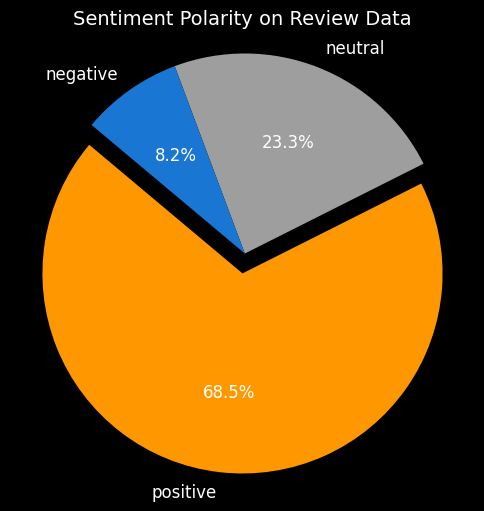

In [ ]:
import matplotlib.pyplot as plt

# Analisis sentimen
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]

# Hitung jumlah sentimen
sentiment_counts = clean_df['polarity'].value_counts()
print("Hasil jumlah sentimen:")
print(sentiment_counts)

# Warna dan explode
color_theme = {
    'positive': '#ff9800',
    'negative': '#1976d2',
    'neutral': '#9e9e9e'
}
colors = [color_theme.get(label, '#cccccc') for label in sentiment_counts.index]
explode = [0.1 if label == 'positive' else 0 for label in sentiment_counts.index]

# Pie chart
plt.style.use('dark_background')
plt.figure(figsize=(6, 6))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=140,
    textprops={'fontsize': 12},
    explode=explode
)
plt.title('Sentiment Polarity on Review Data', fontsize=14)
plt.axis('equal')
plt.show()

### Eksplorasi Label

In [ ]:
# Mengatur batas maksimum panjang teks yang ditampilkan di setiap kolom menjadi 3000 karakter.
pd.set_option('display.max_colwidth', 3000)

# Menyaring data untuk mengambil hanya tweet yang memiliki sentimen positif.
positive_tweets = clean_df[clean_df['polarity'] == 'positive']

# Mengambil kolom-kolom yang relevan dari data tweet positif.
positive_tweets = positive_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]

# Mengurutkan tweet berdasarkan nilai skor polaritas tertinggi ke terendah.
positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)

# Mengatur ulang indeks DataFrame dari awal (mulai dari nol).
positive_tweets = positive_tweets.reset_index(drop=True)

# Menyesuaikan indeks agar dimulai dari angka 1.
positive_tweets.index += 1

In [ ]:
# Menyesuaikan tampilan Pandas agar dapat memperlihatkan isi kolom hingga 3000 karakter.
pd.set_option('display.max_colwidth', 3000)

# Menyaring data untuk mendapatkan tweet dengan sentimen negatif saja.
negative_tweets = clean_df[clean_df['polarity'] == 'negative']

# Menyimpan hanya kolom-kolom yang dibutuhkan dari tweet negatif.
negative_tweets = negative_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]

# Mengurutkan data berdasarkan skor polaritas dari nilai terendah ke tertinggi.
negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=True)

# Mengambil 10 data teratas setelah pengurutan (tweet dengan polaritas paling negatif).
negative_tweets = negative_tweets[0:10]

# Mengatur ulang nomor indeks agar dimulai dari nol.
negative_tweets = negative_tweets.reset_index(drop=True)

# Menyesuaikan indeks agar dimulai dari angka 1 untuk tampilan yang lebih rapi.
negative_tweets.index += 1

In [ ]:
# Menyesuaikan pengaturan tampilan Pandas agar kolom dapat memuat teks panjang hingga 3000 karakter.
pd.set_option('display.max_colwidth', 3000)

# Menyaring DataFrame untuk memperoleh tweet yang bersentimen netral.
neutral_tweets = clean_df[clean_df['polarity'] == 'neutral']

# Mengambil kolom-kolom tertentu yang diperlukan dari tweet netral.
neutral_tweets = neutral_tweets[['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]

# Mengurutkan data berdasarkan skor polaritas, bisa dari besar ke kecil atau sebaliknya.
neutral_tweets = neutral_tweets.sort_values(by='polarity_score', ascending=False)  # Bisa juga ascending=True

# Menyeleksi 10 entri teratas setelah pengurutan dilakukan.
neutral_tweets = neutral_tweets[0:10]

# Mereset indeks agar dimulai dari nol kembali.
neutral_tweets = neutral_tweets.reset_index(drop=True)

# Menambahkan 1 ke seluruh indeks untuk tampilan yang lebih rapi.
neutral_tweets.index += 1

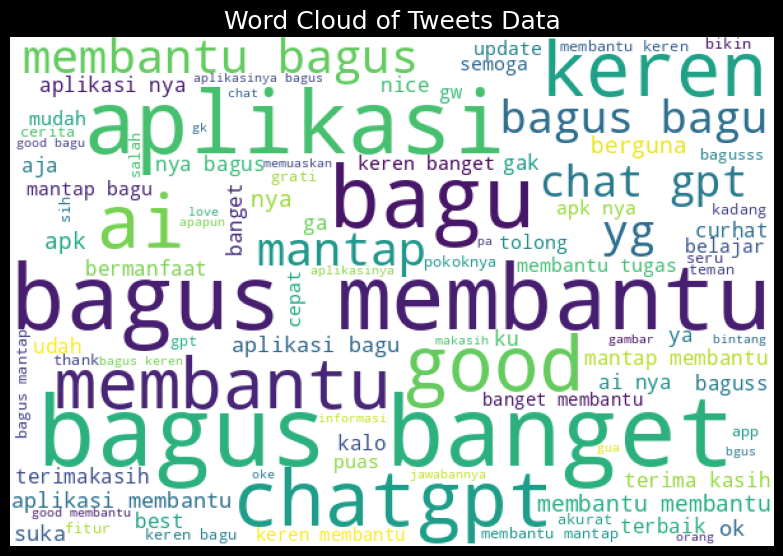

In [ ]:
# Menginisialisasi variabel kosong 'list_words' untuk menampung semua kata dari teks yang telah dibersihkan.
list_words = ''

# Melakukan perulangan untuk setiap tweet dalam kolom 'text_stopword' dari DataFrame 'clean_df'.
for tweet in clean_df['text_stopword']:
    # Melakukan iterasi untuk setiap kata dalam tweet tersebut.
    for word in tweet:
        # Menambahkan kata ke variabel 'list_words' dengan spasi sebagai pemisah.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan ukuran tertentu dan latar belakang putih.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat plot dan sumbu untuk menampilkan hasil WordCloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menambahkan judul ke visualisasi WordCloud.
ax.set_title('Word Cloud of Tweets Data', fontsize=18)

# Menonaktifkan garis grid pada grafik.
ax.grid(False)

# Menampilkan WordCloud di dalam plot.
ax.imshow((wordcloud))

# Menyesuaikan layout agar tampil lebih rapi.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu X dan Y.
ax.axis('off')

# Memunculkan visualisasi WordCloud.
plt.show()

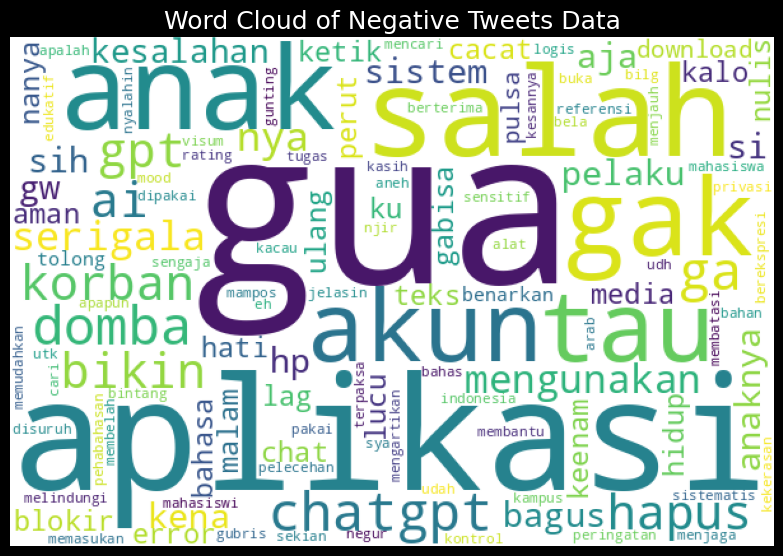

In [ ]:
# Inisialisasi variabel kosong 'list_words' untuk menampung seluruh kata dari tweet negatif yang telah dibersihkan.
list_words = ''

# Melakukan loop untuk setiap data dalam kolom 'text_stopword' milik DataFrame 'negative_tweets'.
for tweet in negative_tweets['text_stopword']:
    # Loop untuk mengambil setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words' dengan spasi sebagai pemisah.
        list_words += ' ' + (word)

# Membuat visualisasi WordCloud dengan spesifikasi ukuran dan tampilan tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Menyiapkan canvas untuk menampilkan WordCloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Memberikan judul pada visualisasi.
ax.set_title('Word Cloud of Negative Tweets Data', fontsize=18)

# Menonaktifkan tampilan grid pada sumbu.
ax.grid(False)

# Menampilkan WordCloud di dalam plot.
ax.imshow(wordcloud)

# Menyesuaikan tampilan layout agar lebih rapi.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu X dan Y agar fokus pada WordCloud.
ax.axis('off')

# Menampilkan hasil visualisasi WordCloud ke layar.
plt.show()

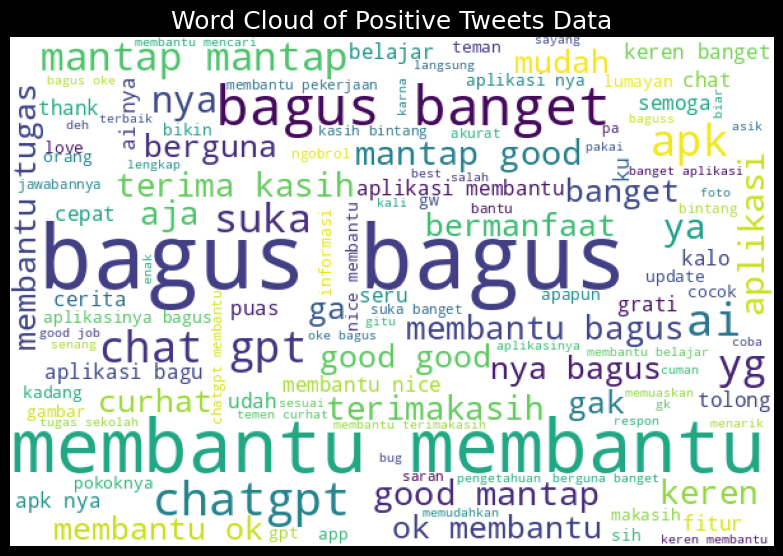

In [ ]:
# Menginisialisasi variabel kosong 'list_words' untuk menampung seluruh kata dari tweet positif yang telah dibersihkan.
list_words = ''

# Melakukan iterasi pada setiap tweet di kolom 'text_stopword' dari DataFrame 'positive_tweets'.
for tweet in positive_tweets['text_stopword']:
    # Iterasi setiap kata dalam tweet tersebut.
    for word in tweet:
        # Menambahkan kata ke dalam variabel 'list_words' dengan spasi sebagai pemisah.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan ukuran dan pengaturan tampilan tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Menyusun plot untuk menampilkan WordCloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menambahkan judul pada tampilan WordCloud.
ax.set_title('Word Cloud of Positive Tweets Data', fontsize=18)

# Mematikan tampilan grid pada plot.
ax.grid(False)

# Menampilkan WordCloud di dalam plot.
ax.imshow(wordcloud)

# Menyesuaikan tata letak agar lebih rapi tanpa padding tambahan.
fig.tight_layout(pad=0)

# Menyembunyikan tampilan sumbu agar visualisasi lebih bersih.
ax.axis('off')

# Menampilkan hasil WordCloud.
plt.show()

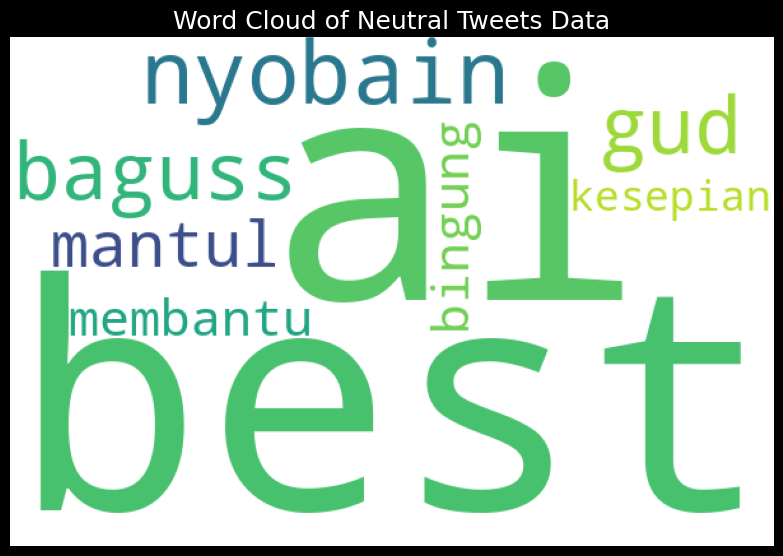

In [ ]:
# Menginisialisasi variabel kosong 'list_words' untuk menyimpan seluruh kata dari tweet netral yang telah diproses.
list_words = ''

# Melakukan iterasi terhadap setiap tweet netral yang sudah dibersihkan dari stopword.
for tweet in neutral_tweets['text_stopword']:
    for word in tweet:
        # Menambahkan kata ke dalam variabel 'list_words', dipisahkan dengan spasi.
        list_words += ' ' + word

# Membuat visualisasi WordCloud dengan konfigurasi tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Menyusun plot untuk menampilkan WordCloud.
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Neutral Tweets Data', fontsize=18)  # Menambahkan judul
ax.grid(False)                                                  # Menonaktifkan grid
ax.imshow(wordcloud)                                            # Menampilkan WordCloud
fig.tight_layout(pad=0)                                         # Menyesuaikan tata letak
ax.axis('off')                                                  # Menyembunyikan sumbu
plt.show()                                                      # Menampilkan hasil visualisasi

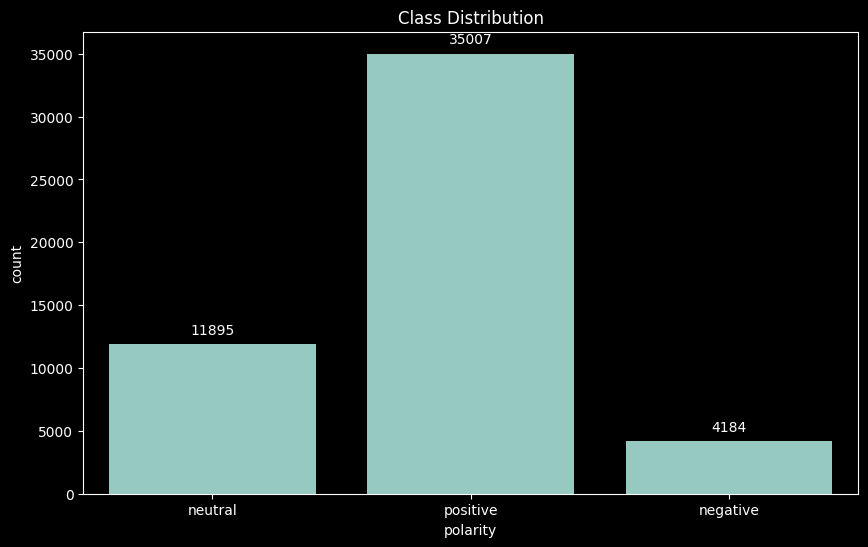

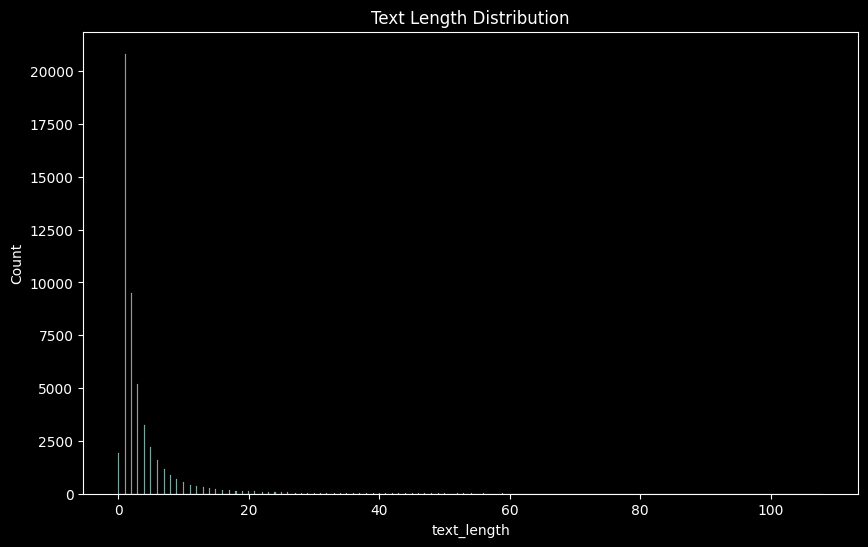

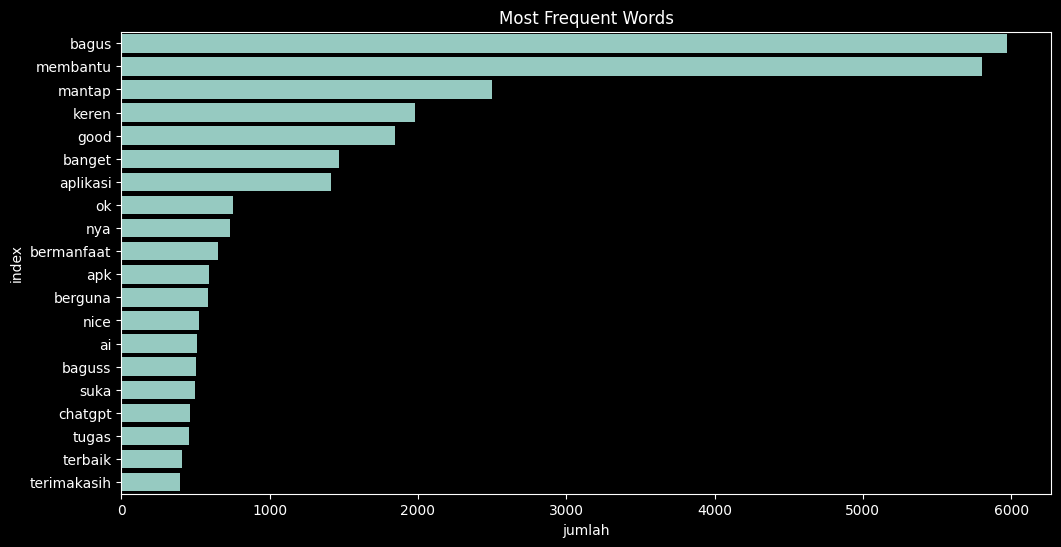

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Menentukan ukuran tampilan plot pertama
plt.figure(figsize=(10, 6))

# Membuat visualisasi distribusi kelas berdasarkan label polaritas
class_dist_plot = sns.countplot(x='polarity', data=clean_df)
plt.title('Class Distribution')

# Menambahkan label jumlah di atas tiap batang pada diagram
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='center',
                             xytext=(0, 10),
                             textcoords='offset points')

plt.show()

# Menentukan ukuran tampilan plot kedua
plt.figure(figsize=(10, 6))

# Menghitung panjang teks untuk setiap entri berdasarkan jumlah kata
clean_df['text_length'] = clean_df['text_akhir'].apply(lambda x: len(x.split()))

# Membuat histogram dari distribusi panjang teks
sns.histplot(clean_df['text_length'])
plt.title('Text Length Distribution')
plt.show()

# Menentukan ukuran tampilan plot ketiga
plt.figure(figsize=(12, 6))

# Membuat visualisasi kata-kata yang paling sering muncul menggunakan TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_df['text_akhir'])

# Membuat DataFrame dari hasil transformasi TF-IDF
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Menjumlahkan skor TF-IDF dari setiap kata dan memilih 20 kata teratas
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)

# Membuat barplot dari kata-kata paling sering berdasarkan nilai TF-IDF
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

### Data Splitting dan Ekstraksi Fitur dengan TF-IDF

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score

In [ ]:
clean_df.head(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity,text_length
0,bc45f16f-3d9c-4780-9cc7-0f799b24a539,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,belum nyobain 🙏,3,0,NaN,2025-04-02 13:10:38,NaN,NaN,NaN,belum nyobain,belum nyobain,belum nyobain,"[belum, nyobain]",[nyobain],nyobain,0,neutral,1
1,d0b0a2a9-3bbb-432a-b218-5e46c7f23ebb,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Bagus bener, bener Bagus",5,0,1.2025.084,2025-04-02 13:10:14,NaN,NaN,1.2025.084,Bagus bener bener Bagus,bagus bener bener bagus,bagus bener bener bagus,"[bagus, bener, bener, bagus]","[bagus, bener, bener, bagus]",bagus bener bener bagus,10,positive,4


In [ ]:
# Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = clean_df['text_akhir']
y = clean_df['polarity']

In [ ]:
# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8 )
X_tfidf = tfidf.fit_transform(X)

In [ ]:
# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
features_df

,ai,aja,ajak,akun,akurat,amazing,anak,and,apapun,apk,...,udh,update,versi,very,wawasan,wow,ya,yaa,yg,you
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51081,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51082,0.503847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51083,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51084,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

### Pemodelan Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB

# Membuat objek model Naive Bayes (Bernoulli Naive Bayes)
naive_bayes = BernoulliNB()

# Melatih model Naive Bayes pada data pelatihan
naive_bayes.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_nb = naive_bayes.predict(X_train.toarray())
y_pred_test_nb = naive_bayes.predict(X_test.toarray())

# Evaluasi akurasi model Naive Bayes
accuracy_train_nb = accuracy_score(y_pred_train_nb, y_train)
accuracy_test_nb = accuracy_score(y_pred_test_nb, y_test)

# Menampilkan akurasi
print('Naive Bayes - accuracy_train:', accuracy_train_nb)
print('Naive Bayes - accuracy_test:', accuracy_test_nb)

Naive Bayes - accuracy_train: 0.8669129881569932
Naive Bayes - accuracy_test: 0.863671951458211


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Membuat objek model Random Forest
random_forest = RandomForestClassifier()

# Melatih model Random Forest pada data pelatihan
random_forest.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = random_forest.predict(X_train.toarray())
y_pred_test_rf = random_forest.predict(X_test.toarray())

# Evaluasi akurasi model Random Forest
accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test)

# Menampilkan akurasi
print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 0.9558823529411765
Random Forest - accuracy_test: 0.9138774711293796


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Membuat objek model Logistic Regression
logistic_regression = LogisticRegression()

# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = logistic_regression.predict(X_train.toarray())
y_pred_test_lr = logistic_regression.predict(X_test.toarray())

# Evaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)

# Evaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.9203533326808261
Logistic Regression - accuracy_test: 0.9180857310628303


### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Membuat objek model Decision Tree
decision_tree = DecisionTreeClassifier()

# Melatih model Decision Tree pada data pelatihan
decision_tree.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_dt = decision_tree.predict(X_train.toarray())
y_pred_test_dt = decision_tree.predict(X_test.toarray())

# Evaluasi akurasi model Decision Tree
accuracy_train_dt = accuracy_score(y_pred_train_dt, y_train)
accuracy_test_dt = accuracy_score(y_pred_test_dt, y_test)

# Menampilkan akurasi
print('Decision Tree - accuracy_train:', accuracy_train_dt)
print('Decision Tree - accuracy_test:', accuracy_test_dt)

Decision Tree - accuracy_train: 0.9558823529411765
Decision Tree - accuracy_test: 0.8971422979056567


In [ ]:
import pandas as pd

# Membuat DataFrame untuk hasil akurasi
results_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'Random Forest', 'Logistic Regression', 'Decision Tree'],
    'Accuracy Train': [accuracy_train_nb, accuracy_train_rf, accuracy_train_lr, accuracy_train_dt],
    'Accuracy Test': [accuracy_test_nb, accuracy_test_rf, accuracy_test_lr, accuracy_test_dt]
})
# Menampilkan hanya kolom "Accuracy Test"
accuracy_test_only = results_df[['Model', 'Accuracy Test']]
print(accuracy_test_only)

                 Model  Accuracy Test
0          Naive Bayes       0.863672
1        Random Forest       0.913877
2  Logistic Regression       0.918086
3        Decision Tree       0.897142


In [ ]:
# Mengurutkan DataFrame berdasarkan kolom "Accuracy Test" dari tertinggi ke terendah
accuracy_test_sorted = accuracy_test_only.sort_values(by='Accuracy Test', ascending=False)

# Menampilkan DataFrame yang telah diurutkan
print(accuracy_test_sorted)

                 Model  Accuracy Test
2  Logistic Regression       0.918086
1        Random Forest       0.913877
3        Decision Tree       0.897142
0          Naive Bayes       0.863672


Model dengan performa terbaik adalah Logistic Regression dengan akurasi 91.81%, diikuti oleh Random Forest (91.39%).

Decision Tree menempati posisi ketiga dengan akurasi 89.71%, sedangkan Naive Bayes memiliki performa terendah di antara keempat model dengan akurasi 86.37%.

Selisih akurasi antar model relatif kecil, menunjukkan bahwa keempat model masih cukup kompetitif. Namun, Logistic Regression memiliki keunggulan tipis dalam hal ketepatan klasifikasi pada data uji.

In [ ]:
# Input kalimat baru dari pengguna
kalimat_baru = input("Masukkan kalimat baru: ")

# 1. Membersihkan karakter tidak penting (sama dengan 'text_clean')
kalimat_clean = preprocess_text(kalimat_baru)

# 2. Case folding (sama dengan 'text_casefoldingText')
kalimat_casefold = kalimat_clean.lower()

# 3. Ganti slang word (sama dengan 'text_slangwords')
kalimat_slang = replace_slang(kalimat_casefold)

# 4. Tokenisasi (sama dengan 'text_tokenizingText')
kalimat_token = word_tokenize(kalimat_slang)

# 5. Hapus stopword (sama dengan 'text_stopword')
stop_words = set(stopwords.words('indonesian'))
kalimat_stopword = [word for word in kalimat_token if word not in stop_words]

# 6. Gabungkan kembali menjadi kalimat akhir (sama dengan 'text_akhir')
kalimat_final = ' '.join(kalimat_stopword)

# Transform ke TF-IDF dan prediksi
X_kalimat_baru = tfidf.transform([kalimat_final])
prediksi_sentimen = logistic_regression.predict(X_kalimat_baru)

# Tampilkan hasil
if prediksi_sentimen[0] == 'positive':
    print("Sentimen kalimat baru adalah POSITIF.")
elif prediksi_sentimen[0] == 'neutral':
    print("Sentimen kalimat baru adalah NETRAL.")
else:
    print("Sentimen kalimat baru adalah NEGATIF.")

Masukkan kalimat baru: chatgpt sangat membantu dalam mengerjakan pekerjaan yang kompleks
Sentimen kalimat baru adalah POSITIF.
